In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/test.csv


In [2]:
TRAIN_PATH = "/kaggle/input/playground-series-s6e2/train.csv"
TEST_PATH  = "/kaggle/input/playground-series-s6e2/test.csv"
SUB_PATH   = "/kaggle/input/playground-series-s6e2/sample_submission.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)
sub_df   = pd.read_csv(SUB_PATH)

print(train_df.shape, test_df.shape, sub_df.shape)
train_df.head()

(630000, 15) (270000, 14) (270000, 2)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [3]:
TARGET = "Heart Disease"
ID_COL = "id";

print("Missing values in y:", train_df[TARGET].isna().sum())
# Drop rows where y is missing 
train_clean = train_df.dropna(subset=[TARGET]).copy()

#Separate features (X) and target (y)
X = train_clean.drop(columns=[TARGET,ID_COL])
X_test = test_df.drop(columns=[ID_COL])

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)


Missing values in y: 0
X shape: (630000, 13)
X_test shape: (270000, 13)


In [4]:
y_label = train_clean[TARGET].astype(str)   # keep for EDA / report

#Encode target for modeling (Presence=1, Absence=0)
label_to_int = {"Absence": 0, "Presence": 1}
y = y_label.map(label_to_int)


# Safety check
if y.isna().any():
    bad = y_label[y.isna()].unique()
    raise ValueError(f"Unexpected target labels found in {TARGET}: {bad}")

y = y.astype(int)

print("y shape:", y.shape, "| y unique:", sorted(y.unique()))
print("Target labels:", y_label.unique())

y shape: (630000,) | y unique: [np.int64(0), np.int64(1)]
Target labels: ['Presence' 'Absence']


# Basic Target Plot 

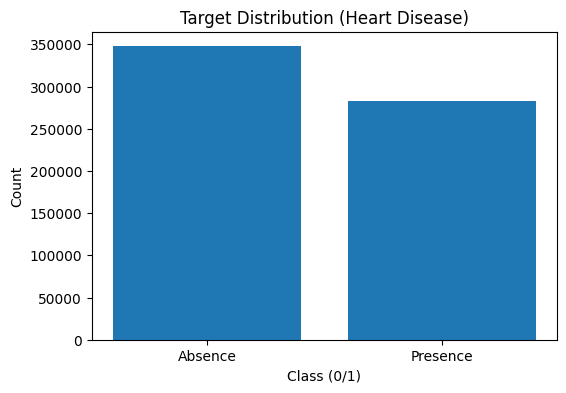

In [5]:
target_counts = train_clean[TARGET].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution (Heart Disease)")
plt.xlabel("Class (0/1)")
plt.ylabel("Count")
plt.show()

In [6]:
# 3) Missing values summary
missing_train = X.isna().sum().sort_values(ascending=False)
missing_test  = X_test.isna().sum().sort_values(ascending=False)

print("\nTop missing (train):")
print(missing_train[missing_train > 0].head(20))

print("\nTop missing (test):")
print(missing_test[missing_test > 0].head(20))



Top missing (train):
Series([], dtype: int64)

Top missing (test):
Series([], dtype: int64)


In [7]:
#Detect numeric vs categorical columns from X
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Report

## Histograms for a few numeric columns

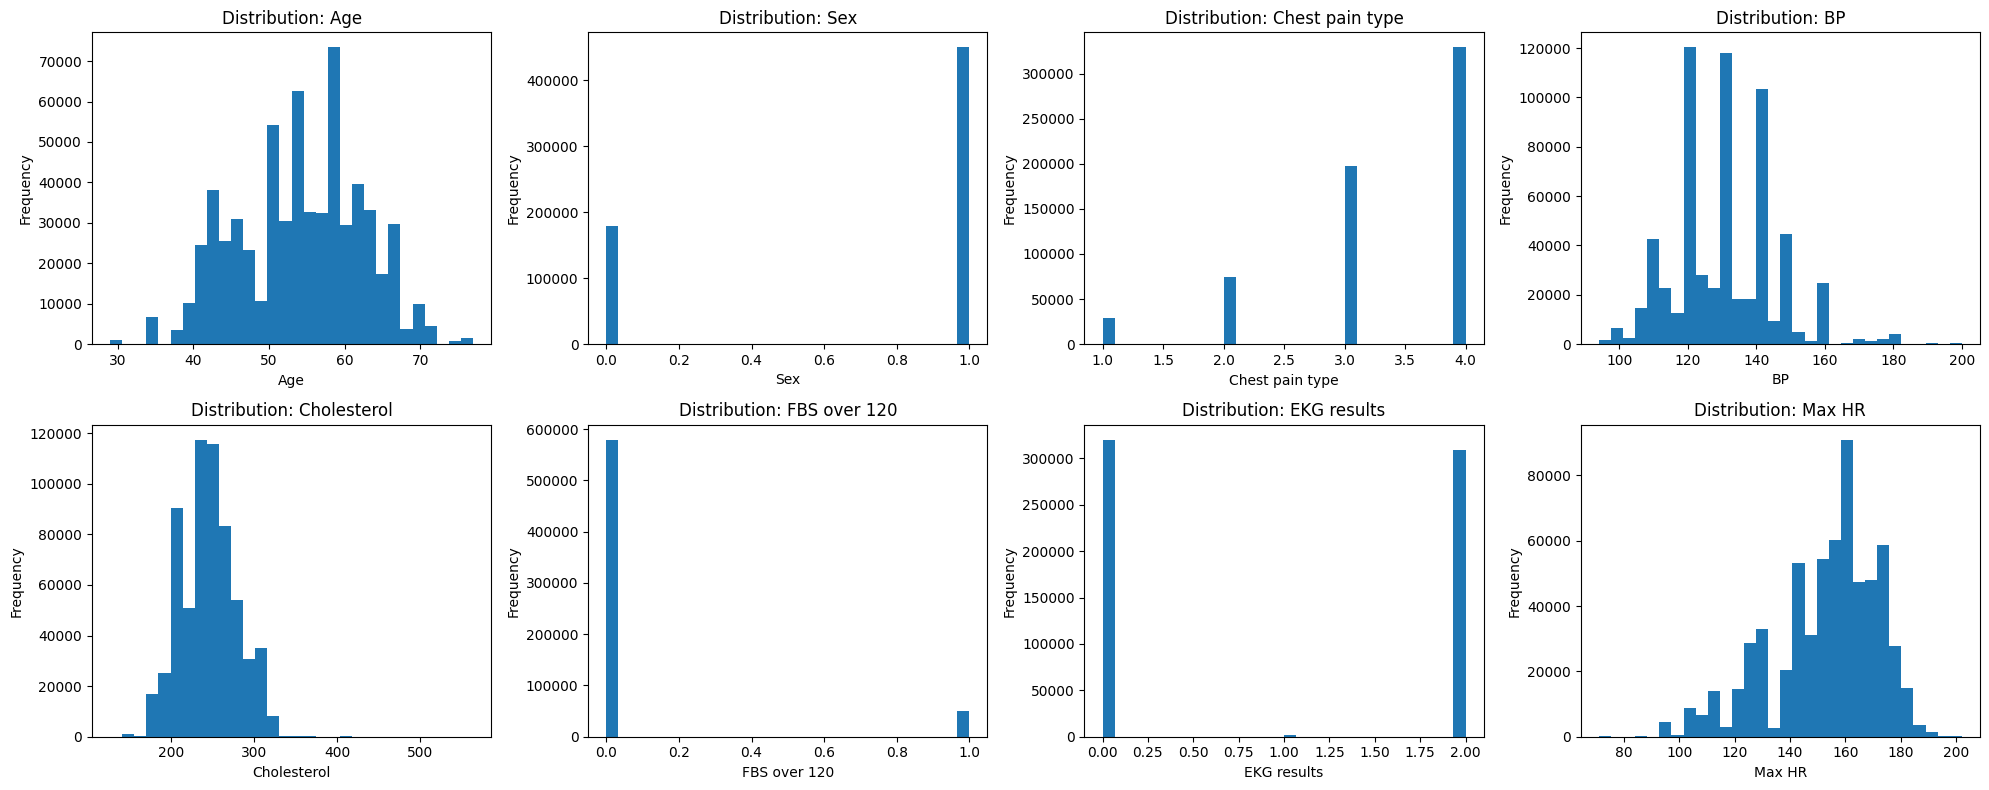

In [8]:
top_num = num_cols[:8]  # first 8 numeric columns

n_cols = 4
n_plots = len(top_num)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # 2D -> 1D

for i, c in enumerate(top_num):
    axes[i].hist(X[c].dropna(), bins=30)
    axes[i].set_title(f"Distribution: {c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Frequency")
    
for j in range(n_plots, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Correlation Heatmap (Numeric only)

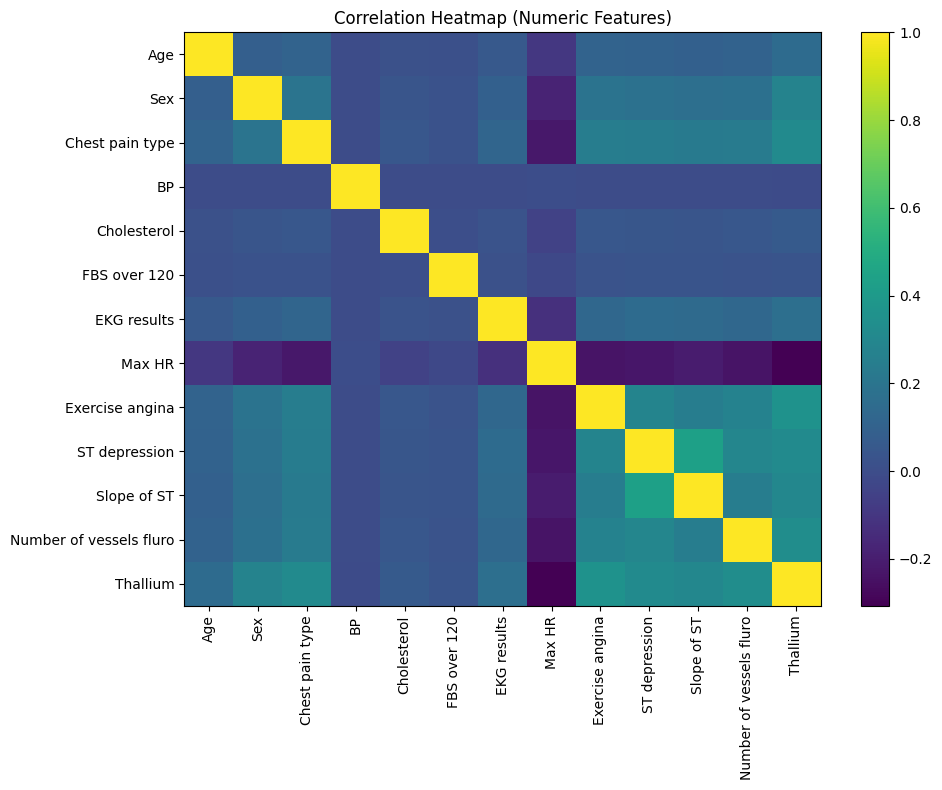

In [9]:
if len(num_cols) > 1:
    corr = X[num_cols].corr()

    plt.figure(figsize=(10,8))
    plt.imshow(corr, aspect='auto')
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()

# Missing Handle and Categorical Encode (Pipeline)

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

# 2) Pipelines for each type
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#Combine into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

#Fit on train X and transform train/test
X_prepared = preprocessor.fit_transform(X)
X_test_prepared = preprocessor.transform(X_test)

print("Prepared X shape:", X_prepared.shape)
print("Prepared X_test shape:", X_test_prepared.shape)

Numeric cols: 13
Categorical cols: 0
Prepared X shape: (630000, 13)
Prepared X_test shape: (270000, 13)


# Train and Validate

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 1) Full pipeline = preprocess + model
model = LogisticRegression(max_iter=3000, solver="saga")

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

# 2) Stratified K-Fold (keeps class balance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) ROC-AUC cross validation
scores = cross_val_score(
    clf, X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("ROC-AUC scores (5 folds):", scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC :", scores.std())

ROC-AUC scores (5 folds): [0.94950544 0.9484495  0.94946518 0.94892592 0.94964583]
Mean ROC-AUC: 0.9491983757007312
Std ROC-AUC : 0.0004473764436291072


# Train on FULL data + Predict on test + Create submission.csv

In [12]:

clf.fit(X, y)

test_probs = clf.predict_proba(X_test)[:, 1]

# submission column name (safe way)
pred_col = sub_df.columns[1]
sub_df[pred_col] = test_probs

sub_df.to_csv("submission.csv", index=False)

print("\nSaved: submission.csv")
print(sub_df.head())
print("\nPrediction min/max:", sub_df[pred_col].min(), sub_df[pred_col].max())


Saved: submission.csv
       id  Heart Disease
0  630000       0.966373
1  630001       0.004271
2  630002       0.993669
3  630003       0.016972
4  630004       0.126957

Prediction min/max: 0.00019095020299319144 0.999992689938851


In [13]:
import xgboost as xgb
print("xgboost version:", xgb.__version__)

xgboost version: 3.1.0


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb_model)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_scores = cross_val_score(
    xgb_clf, X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("XGBoost ROC-AUC scores:", xgb_scores)
print("Mean ROC-AUC:", xgb_scores.mean())
print("Std  ROC-AUC:", xgb_scores.std())

XGBoost ROC-AUC scores: [0.95573909 0.95469434 0.9555366  0.95513535 0.95589835]
Mean ROC-AUC: 0.9554007466843965
Std  ROC-AUC: 0.00043588656148371284
